## Solve Autoencoder and Eigenfunction of 2D systems. 

### load modules/packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
import random
from tqdm import tqdm
import os
import sys
import time

sys.path.append('./colvars-finder')
from colvarsfinder.core import AutoEncoderTask, EigenFunctionTask
from colvarsfinder.nn import AutoEncoder, EigenFunctions 
from colvarsfinder.utils import WeightedTrajectory, integrate_sde_overdamped, calc_weights

In [2]:
e_dims = [5,3,2]
d_dims = [2,1,4]
ae = AutoEncoder(e_dims, d_dims)


In [4]:
print (ae)
param = ae.get_params_of_cv(0)
print (param)
param = ae.get_params_of_cv(-1)
print (param)

AutoEncoder(
  (encoder): Sequential(
    (1): Linear(in_features=5, out_features=3, bias=True)
    (activation 1): Tanh()
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (1): Linear(in_features=2, out_features=1, bias=True)
    (activation 1): Tanh()
    (2): Linear(in_features=1, out_features=4, bias=True)
  )
)
[['1.weight', Parameter containing:
tensor([[ 0.3028,  0.0230,  0.0234,  0.1598, -0.3711],
        [-0.1084,  0.0948,  0.0484, -0.2451,  0.1381],
        [ 0.1782, -0.0057,  0.3238,  0.2881,  0.4331]], requires_grad=True)], ['1.bias', Parameter containing:
tensor([ 0.1434, -0.2369, -0.1652], requires_grad=True)], ['2.weight', tensor([[-0.0115,  0.4522, -0.4188]], grad_fn=<SliceBackward0>)], ['2.bias', tensor([0.3030], grad_fn=<SliceBackward0>)]]


AssertionError: index -1 exceeded the range [0, 1]!

###  defines potential of 2d system

In [4]:
            
class TripleWellPotAlongCircle :
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
      # angle in [-pi, pi] 

      theta = np.arctan2(x[1], x[0])
      # radius
      r = np.sqrt( x[0] * x[0] + x[1] * x[1] )

      v_vec = np.zeros(len(x))
      for idx in range(len(x)) :
          # potential V_1
          if theta > math.pi / 3 : 
            v_vec = (1-(theta * 3 / math.pi- 1.0)**2)**2
          if theta < - math.pi / 3 : 
            v_vec = (1-(theta * 3 / math.pi + 1.0)**2)**2
          if theta > - math.pi / 3 and theta < math.pi / 3:
            v_vec = 3.0 / 5.0 - 2.0 / 5.0 * np.cos(3 * theta)  
      # potential V_2
      v_vec = v_vec * 1.0 + (r - 1)**2 * 1.0 / self.eps + 5.0 * np.exp(-5.0 * r**2) 
      return v_vec

    def gradV(self, x): 
      # angle
      theta = np.arctan2(x[1], x[0])
      # radius
      r = np.sqrt( x[0] * x[0] + x[1] * x[1] )

      if np.fabs(r) < 1e-8: 
          print ("warning: radius is too small! r=%.4e" % r)
      dv1_dangle = 0.0
      # derivative of V_1 w.r.t. angle
      if theta > math.pi / 3: 
        dv1_dangle = 12 / math.pi * (theta * 3 / math.pi - 1) * ((theta * 3 / math.pi- 1.0)**2-1)
      if theta < - math.pi / 3: 
        dv1_dangle = 12 / math.pi * (theta * 3 / math.pi + 1) * ((theta * 3 / math.pi + 1.0)**2-1)
      if theta > -math.pi / 3 and theta < math.pi / 3:
        dv1_dangle = 1.2 * math.sin (3 * theta)
      # derivative of V_2 w.r.t. angle
      dv2_dangle = 0
      # derivative of V_2 w.r.t. radius
      dv2_dr = 2.0 * (r-1.0) / self.eps - 50.0 * r * np.exp(-r**2/0.2)

      return np.array((-(dv1_dangle + dv2_dangle) * x[1] / (r * r)+ dv2_dr * x[0] / r,  (dv1_dangle + dv2_dangle) * x[0] / (r * r)+ dv2_dr * x[1] / r))



### define parameters

In [6]:
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
    random.seed(seed)
    
seed = 30
# certain potentials depend on epsilon 
eps = 0.5
beta = 1.0 

pot = TripleWellPotAlongCircle(beta, eps)
pot_name = type(pot).__name__

print ('potential name: %s' % pot_name) 

x_domain = [-3.5, 3.5]
y_domain = [-3.5, 3.5]

v_min_max = [0.3,8]

# for data generation
delta_t = 0.001
N = 500000

save_fig_to_file = False

# path to store log data
sys_path = pot_name 

print ('\nOutput directory: {}\n'.format(sys_path))

if not os.path.exists(sys_path):
    os.makedirs(sys_path)
    
set_all_seeds(seed)

potential name: TripleWellPotAlongCircle

Output directory: TripleWellPotAlongCircle



### visualise the potential

min and max values of potential: (0.0253, 32.0839)
(100, 150) (100, 150) (100, 150)


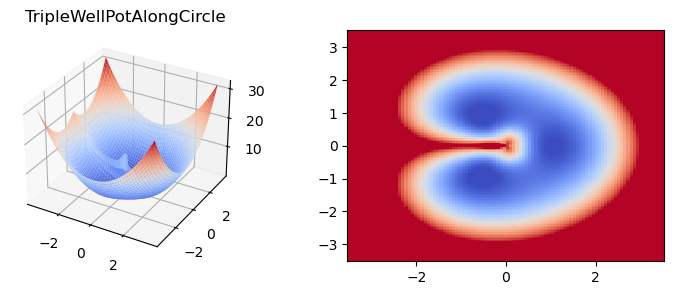

In [7]:
nx = 100
ny = 150
dx = (x_domain[1] - x_domain[0]) / nx
dy = (y_domain[1] - y_domain[0]) / ny

gridx = np.linspace(x_domain[0], x_domain[1], nx)
gridy = np.linspace(y_domain[0], y_domain[1], ny)
x_plot = np.outer(gridx, np.ones(ny)) 
y_plot = np.outer(gridy, np.ones(nx)).T 

x2d = np.concatenate((x_plot.reshape(nx * ny, 1), y_plot.reshape(nx * ny, 1)), axis=1)

pot_on_grid = np.array([pot.V(x) for x in x2d]).reshape(nx, ny)
print ( "min and max values of potential: (%.4f, %.4f)" % (pot_on_grid.min(), pot_on_grid.max()) )

fig = plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)
ax0.set_title(pot_name)
print (x_plot.shape, y_plot.shape, pot_on_grid.shape)

ax0.plot_surface(x_plot, y_plot, pot_on_grid, cmap='coolwarm', edgecolor='none')
ax1.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm',shading='auto', vmin=v_min_max[0], vmax=v_min_max[1])

if save_fig_to_file :
    filename = f"{sys_path}/{pot_name}.jpg" 
    fig.savefig(filename)
    print ( "potential profiles saved to file: %s" % filename )


### generate trajectory data

In [8]:
x_0 = np.array([0, 1])
traj_filename = 'traj.txt'
csv_filename = 'output.csv'

integrate_sde_overdamped(pot, N, sys_path, X0=x_0, pre_steps=0, step_size=delta_t, 
                         traj_txt_filename=traj_filename, csv_filename='output.csv', 
                         report_interval=100, report_interval_stdout=100000)


Directory to save trajectory ouptuts: TripleWellPotAlongCircle
sampling beta=1.000, dt=0.001

First, burning, total number of steps = 0
Next, run 500000 steps
step=0, time=0.000, energy=0.552
step=100000, time=100.000, energy=0.614
step=200000, time=200.000, energy=0.153
step=300000, time=300.000, energy=0.924
step=400000, time=400.000, energy=0.654


### calculate weights and show histogram


=============Calculate Weights============
Reading potential from: TripleWellPotAlongCircle/output.csv

Whole data:
    Time (ps)    Energy
0        0.0  0.551535
1        0.1  0.428255
2        0.2  1.521582
3        0.3  4.701791
4        0.4  3.770972
5        0.5  0.620497
6        0.6  0.883020
7        0.7  0.905797

Use 1th column to reweight, name: Energy

sampling beta=1.0, system beta=1.0

Weight:
    weight
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0 

Summary of weights:
        weight
count  5000.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
weights saved to: TripleWellPotAlongCircle/weights.txt


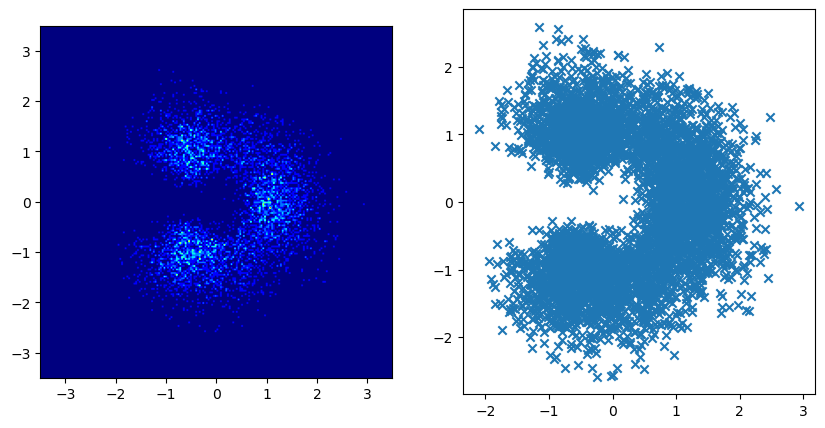

In [9]:
traj_weight_fullname = f'{sys_path}/weights.txt'
traj_fullname = f'{sys_path}/{traj_filename}'
csv_fullname = f'{sys_path}/{csv_filename}'
calc_weights(csv_fullname, pot.beta, pot.beta, traj_weight_filename=traj_weight_fullname)

trajectory = np.loadtxt(traj_fullname)

### Plot the trajectory 
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
nx = ny = 200
h = np.histogram2d(trajectory[:,1], trajectory[:,2], bins=[nx, ny], range=[[x_domain[0],x_domain[1]],[y_domain[0],y_domain[1]]])[0]
s = sum(sum(h))
im = ax0.imshow(h.T / (s * dx * dy), origin = "lower", \
                extent=[x_domain[0],x_domain[1],y_domain[0], y_domain[1]], \
                cmap=cm.jet, vmin=0.0, vmax=0.5)
#fig.colorbar(im, cax=cax, cmap=cm.jet)
#ax0.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm_r', shading='auto')
ax1.scatter(trajectory[:,1], trajectory[:,2], marker='x')
#ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')

if save_fig_to_file :
    filename = f"{sys_path}/traj.jpg" 
    fig.savefig(filename)
    print ("trajectory plot saved to file: %s" % filename)

### function to show the trained model

In [7]:
def plot_cv(cv_model):
    gridx = np.linspace(x_domain[0], x_domain[1], 100)
    gridy = np.linspace(y_domain[0], y_domain[1], 100)
    x_plot = np.outer(gridx, np.ones(100)) 
    y_plot = np.outer(gridy, np.ones(100)).T 

    x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)).float()
    cv_on_grid = cv_model(x2d).detach().numpy()

    for idx in range(k):
        cv = cv_on_grid[:,idx].reshape(100,100)
        #print ( "min and max values of %dth dimension of encoder: (%.4f, %.4f)" % (idx, encoder.min(), encoder.max()) )

        fig = plt.figure(figsize=(12,5))
        ax0 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1 = fig.add_subplot(1, 2, 2)  
        ax0.plot_surface(x_plot, y_plot, cv, cmap='coolwarm', edgecolor='none')
        im = ax1.pcolormesh(x_plot, y_plot, cv, cmap='coolwarm',shading='auto')
        contours = ax1.contour(x_plot, y_plot, cv, 20, colors='black')
        ax1.clabel(contours, inline=True, fontsize=8)
        fig.colorbar(im, ax=ax1)
        if save_fig_to_file :
            fig_name = f"{model_path}/cv_{idx}.jpg"
            fig.savefig(fig_name)
            #print ( "encoder profiles saved to file: %s" % fig_name )
            plt.close()
 

### training autoencoder 


loading weights from file:  TripleWellPotAlongCircle/weights.txt

Weights:
 count    5000.0
mean        1.0
std         0.0
min         1.0
20%         1.0
40%         1.0
50%         1.0
60%         1.0
80%         1.0
max         1.0
Name: 0, dtype: float64

After selecting states whose weights are in [0.000e+00, inf] and renormalization:

Shape of trajectory: (5000, 2)

Weights:
 count    5000.0
mean        1.0
std         0.0
min         1.0
20%         1.0
40%         1.0
50%         1.0
60%         1.0
80%         1.0
max         1.0
Name: 0, dtype: float64

Training starts.
200 epochs in total, batch size: 1000

Train set:
	4000 data, 4 iterations per epoch, 800 iterations in total.
Test set:
	1000 data, 1 iterations per epoch, 200 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.97it/s]


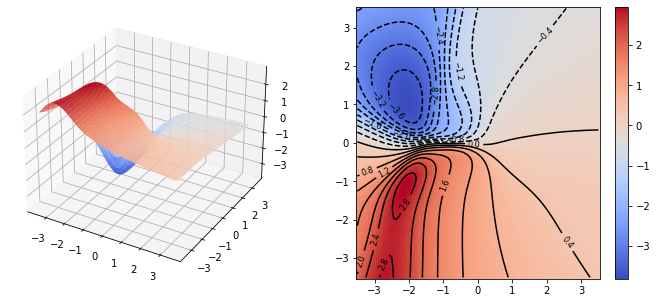

In [8]:
traj = WeightedTrajectory(traj_filename=traj_fullname, weight_filename=traj_weight_fullname)
pp_layer = torch.nn.Identity()

batch_size = 1000
num_epochs = 200
test_ratio = 0.2
learning_rate = 0.005 
optimizer = 'Adam' # 'SGD'
k=1
pp_layer = torch.nn.Identity()

e_dims = [2, 20, 20, 20, k]
d_dims = [k, 20, 20, 2]
model = AutoEncoder(e_dims, d_dims)
model_path = os.path.join(sys_path, f'autoencoder-k={k}-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
train_obj = AutoEncoderTask(traj, pp_layer, model, model_path, learning_rate=learning_rate, 
                            batch_size=batch_size, test_ratio=test_ratio, num_epochs=num_epochs,  verbose=False)

# train autoencoder
train_obj.train()

cv = train_obj.colvar_model()
plot_cv(cv)

## train the eigenfunction, and plot it


Training starts.
200 epochs in total, batch size: 1000

Train set:
	4000 data, 4 iterations per epoch, 800 iterations in total.
Test set:
	1000 data, 1 iterations per epoch, 200 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.16it/s]


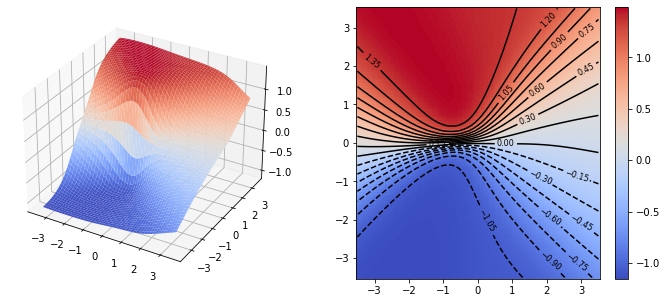

In [9]:

model = EigenFunctions([2, 20, 20, 20, 1], k)
model_path = os.path.join(sys_path, f'eigenfunction-k={k}-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
beta = 1.0
diag_coeff = torch.ones(2)
alpha = 20.0
eig_weights = [1.0, 0.7]
train_obj = EigenFunctionTask(traj, pp_layer, model, model_path, beta, diag_coeff, alpha, eig_weights, 
                              learning_rate=learning_rate, test_ratio=test_ratio, batch_size=batch_size, num_epochs=num_epochs,  verbose=False)
    
# train autoencoder
train_obj.train()

cv = train_obj.colvar_model()
plot_cv(cv)